In [1]:
import pandas as pd
from scipy.spatial import distance
import numpy as np
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

In [2]:
UK_covid_df = pd.read_csv("UK_covid.csv")
UK_covid_df['coord'] = UK_covid_df[['lat','lon']].apply(tuple, axis=1)
UK_covid_df = UK_covid_df.drop(columns= ['lat', 'lon'])
UK_covid_df

,site,# death,coord
0,Adur,34,"(50.84522125, -0.2939300331646212)"
1,Allerdale,59,"(54.70888095, -3.252788011003595)"
2,Amber Valley,76,"(53.02903840000001, -1.4625031096700565)"
3,Arun,46,"(50.830937799999994, -0.5666854639891136)"
4,Ashfield,118,"(56.21137289999999, -3.9614269)"
...,...,...,...
337,Wychavon,93,"(52.1803417, -2.0623136726812445)"
338,Wycombe,87,"(51.66356185, -0.818083680966309)"
339,Wyre,72,"(59.11943975, -2.9708936400463584)"
340,Wyre Forest,100,"(52.38505915, -2.2347966141505187)"


In [23]:
UK_pol_df = pd.read_csv("UK_pol_pop.csv")
UK_pol_df['coord'] = UK_pol_df[['lat','lon']].apply(tuple, axis=1)
UK_pol_df = UK_pol_df.drop(columns= ['lat', 'lon'])
UK_pol_df.head()

,site,no2,pm10,pm2.5,Population,coord
0,Aberdeen,21.323003,12.679401,7.534314,137962,"(57.14369, -2.0981400000000003)"
1,Belfast Centre,29.134035,15.673754,10.273508,618108,"(54.59633, -5.93004)"
2,Birmingham Tyburn,31.486575,18.136199,12.977897,2916458,"(52.51944, -1.80127)"
3,Bristol,27.290171,17.094891,12.165736,1006600,"(51.45523, -2.59665)"
4,Bury,64.735355,23.568150,18.968763,2798000,"(53.6, -2.3)"


In [24]:
n = UK_covid_df.shape[0]
m = UK_pol_df.shape[0]
UK_covid_df['sensor_site_name'] = np.zeros(n)
UK_covid_df['distance from the sensor [km]'] = np.zeros(n)
dist_vect = np.zeros(m)
#associating a station to each UK_covid_df
for idx1, row1 in UK_covid_df.iterrows():
    pos1= np.array(row1['coord'])
    for idx2, row2 in UK_pol_df.iterrows():
        pos2 = np.array(row2['coord']) #position of the sensor
        dst = distance.euclidean(pos1, pos2)
        dist_vect[idx2] = dst
    idx_min = np.where(dist_vect == np.amin(dist_vect))[0][0]
    UK_covid_df.loc[idx1, 'sensor_site_name'] = UK_pol_df.loc[idx_min,'site']
    p = row1['coord'] #sensor's position
    s = UK_pol_df.loc[idx_min, 'coord'] #associated sensor position
    UK_covid_df.loc[idx1, 'distance from the sensor [km]'] = geodesic(p, s).km

In [25]:
threshold = 20
UK_covid_df = UK_covid_df[UK_covid_df['distance from the sensor [km]'] < threshold]
UK_covid_dff = UK_covid_df.groupby(['sensor_site_name'], as_index=False).agg({'# death':  np.sum})

In [26]:
#finally merge the two datasets
df_merged =  UK_covid_dff.merge(UK_pol_df, left_on='sensor_site_name', right_on='site')
df_merged.head()

,sensor_site_name,# death,site,no2,pm10,pm2.5,Population,coord
0,Birmingham Tyburn,2355,Birmingham Tyburn,31.486575,18.136199,12.977897,2916458,"(52.51944, -1.80127)"
1,Bristol,450,Bristol,27.290171,17.094891,12.165736,1006600,"(51.45523, -2.59665)"
2,Bury,601,Bury,64.735355,23.568150,18.968763,2798000,"(53.6, -2.3)"
3,Cardiff Centre,800,Cardiff Centre,24.618499,17.752360,11.066149,460800,"(51.45059000000001, -3.18679)"
4,Carlisle,109,Carlisle,25.497863,16.736710,10.123403,498000,"(54.8951, -2.9382)"


In [27]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
df = df_merged.drop(columns = ['sensor_site_name', 'site', 'coord'])

# Standardizse the features
df_norm = (df-df.mean())/df.std()
df_norm.head()

,# death,no2,pm10,pm2.5,Population
0,2.988487,0.283023,0.033119,0.218368,2.591448
1,-0.310476,-0.003832,-0.278193,-0.103365,0.153342
2,-0.048983,2.555826,1.657064,2.591620,2.440226
3,0.295633,-0.186461,-0.081635,-0.538961,-0.543421
4,-0.900999,-0.126350,-0.385275,-0.912425,-0.495932


In [32]:
# Apply PCA
nc = 5
pca = decomposition.PCA(n_components=nc)
principalDf = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['pc #1', 'pc #2', 'pc #3', 'pc #4', 'pc #5'])
print("Singular values:", pca.singular_values_)

Singular values: [10.68709035  6.43709639  5.67834748  3.45938837  2.26691244]


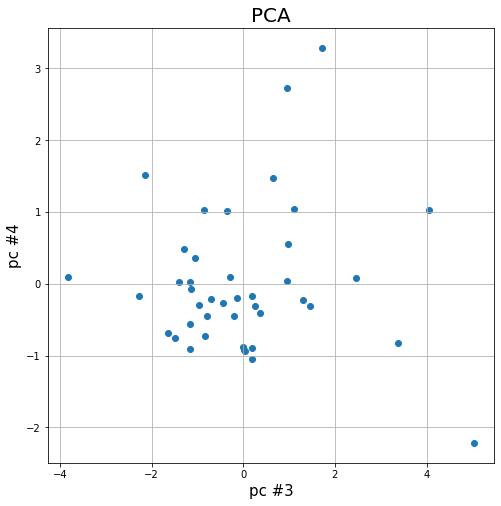

In [33]:
import matplotlib.pyplot as plt
df = principalDf
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 


ax.scatter(df.iloc[:,0], df.iloc[:,1])

ax.grid()
ax.set_xlabel(df.columns[2], fontsize = 15)
ax.set_ylabel(df.columns[3], fontsize = 15)
ax.set_title('PCA', fontsize = 20)
plt.show()

In [30]:
nc = 4

# Apply PCA
pca = decomposition.PCA(n_components=nc)
PCA_df = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['pc #1', 'pc #2', 'pc #3', 'pc #4'])
print("Singular values:", pca.singular_values_)
display(PCA_df)


# Append the target Label columns
target = pd.Series(np.hstack([np.zeros(nc//2),np.ones(nc//2)]) , name='label')

df = pd.concat([df, target], axis = 1)
PCA_df = pd.concat([PCA_df, target], axis = 1)
PCA_df.head()

Singular values: [10.68709035  6.43709639  5.67834748  3.45938837]


,pc #1,pc #2,pc #3,pc #4
0,1.714008,3.288766,1.389166,-0.258155
1,-0.283594,0.095803,-0.227580,0.244819
2,4.051036,1.029249,-1.778320,1.099663
3,-0.434405,-0.264629,0.602996,-0.141527
4,-1.157697,-0.566195,-0.233025,0.445976
5,0.978950,0.559777,-1.392058,-0.397767
6,-0.010025,-0.876358,-0.585903,0.695017
7,-0.710817,-0.205341,-0.567324,-0.218297
8,-2.151755,1.512895,-0.411486,0.426713
9,-0.202749,-0.441661,-1.238392,-1.007866


,pc #1,pc #2,pc #3,pc #4,label
0,1.714008,3.288766,1.389166,-0.258155,0.0
1,-0.283594,0.095803,-0.227580,0.244819,0.0
2,4.051036,1.029249,-1.778320,1.099663,1.0
3,-0.434405,-0.264629,0.602996,-0.141527,1.0
4,-1.157697,-0.566195,-0.233025,0.445976,NaN
